# Rnalib Introduction

The increasing abundance and complexity of biological data requires programmatic approaches for their analysis that allow for the rapid development of custom yet efficient, well-tested and reproducible analysis pipelines. Traditional approaches (e.g., bash command/perl pipelines), that suffer from low readability, maintainability and reproducibility, are increasingly superseded by complex, containerized (e.g., docker/apptainer) analysis pipelines that combine specialized bioinformatics tools with custom scripts developed in higher programming languages such as *Python*, *R* or *Rust*.

Despite not being the fastest option, *Python* is a [popular choice by analysts](https://github.blog/2023-03-02-why-python-keeps-growing-explained/), mainly due to the large number of available (bioinformatics) libraries, its simple and well-documented syntax and its broad utility in the emerging data science field. For this reason, an increasing number of python APIs for the handling of genomics data are being developed. 
While some are mainly wrappers around well-established and efficient bioinformatics tools (e.g., pysam/samtools, pybedtools/BEDTools or cyvcf2/htslib), others are built on popular data wrangling/analysis libraries such as *pandas* or *numpy* (e.g., bioframe/pandas, pyranges/pandas, bionumpy/numpy).

Here, we introduce **rnalib**, a Python library for handling transcriptomics data.
*Rnalib* implements a **transcriptome** class that represents genomic features (such as genes, transcripts or exons) as Python dataclasses and explicitly models their relationships. It provides a secure way for referencing and annotating such features by structuring them into immutable genomic locations (that can, e.g., safely be used in lookup tables) and mutable, arbitrary annotations. 
Users can incrementally add annotations by using a comprehensive set of **genomic iterators** that provide access to the most common genomics data formats (e.g., BAM, BED, VCF, etc.). 
*Genomic iterators* provide a uniform interface to such data sources and are implemented on top of existing, efficient python implementations (pysam, bioframe, pybedtools). 

*Rnalib* provides **efficient access/querying** of feature sequences and annotations and implements various ways to **export** those, e.g., to pandas dataframes, in order to provide seamless integration with other (genomics) libraries and tools.
*Rnalib* is not meant to replace the existing (great) work of others but to complement and integrate it and to fill some missing gaps. 

*Rnalib*'s target audience are bioinformatics analysts and developers and its main design goal is to enable **fast, readable, reproducible and robust development of novel bioinformatics tools and methods**.

## Table of Contents
To introduce *rnalib*, we have compiled a number of ipython notebooks:

This notebook presents the core API of *rnalib*:
* Its [genomic intervals](#Genomic-intervals) implementation
* Its [transcriptome](#Transcriptome-implementation) implementation
* Its [genomic iterators](#Iterators) for efficient iteration over (subregions of) large-scaled genomics datasets based on the pysam library. Iterators keep track of the genomic region of the yielded data, thereby enabling their efficient integration with other data sets
* Its strategies for genomic [feature annotation](#Feature-Annotation)

A [second (advanced usage) notebook](AdvancedUsage.ipynb) presents:
* More advanced usage examples for the topics above
* Various *rnalib* utility functions for working with genomics data

In [a 'related work' notebook](RelatedWork_performance.ipynb), we compare rnalib to a number of related APIs (pybedtools, bioframe, HTSeq) with regard to 
* provided features/approaches
* performance
* common analysis pitfalls that we tried to address in the design of *rnalib*

We also provide a set of tutorials for demonstrating rnalib in realistic usage scenarios:
* [Tutorial: Transcriptome annotation with genemunge, archs4 and mygene.info](Tutorial_transcriptome_annotation.ipynb): annotation with data from public databases
* [Tutorial: SLAM-seq analysis](Tutorial_SLAM-seq.ipynb): Simplified analysis of a SLAM-seq timecourse dataset
* [Tutorial: Comparison of gene annotation sets](Tutorial_compare_annotation_sets.ipynb): Comparison of different gene annotation sets (human and fly)
* [Tutorial: CTCF analysis with rnalib and bioframe](Tutorial_CTCF_analysis.ipynb): Annotation of genes with CTCF sites
* [Tutorial: shRNA analysis](Tutorial_shRNA_analysis.ipynb): a small analysis of shRNA targets

For further API examples, please also consider *rnalib*'s [test classes](https://github.com/popitsch/rnalib/tree/main/tests).

## Requirements
Before executing this notebook, you need to install all required *rnalib* requirements as well as optional libraries needed by this notebook.
It is recommended to do this in a [Python virtual environment](https://rnalib.readthedocs.io/en/latest/readme.html#installation).

This notebook as well as *rnalib*'s testing suite use various **test resources** (genomics data files and indexing structures) that can either be downloaded from the Github repository or 
created by running the *rnalib* `rnalib_create_testdata` script. Please refer to [the rnalib documentation](https://rnalib.readthedocs.io/en/latest/readme.html#test-data) for detailed instructions.
There are two separate test resource sets:

* *test_resources*: small test datasets that are used by *rnalib*'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate *rnalib* under realistic conditions. 

*Rnalib* knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by 'monkeypatching' (rna.__RNALIB_TESTDATA__ = ...) as shown below. Once this is done, test data resources can be accessed via `rna.get_resource(<resource_id>)`. *Rnalib* will recreate these resources only if they are not found in the provided output folder.

In [2]:
# uncomment commands below to install rnalib's requirements 
#%pip install -r https://raw.githubusercontent.com/popitsch/rnalib/main/requirements.txt
# import required libaries 
import os, pathlib, platform, logging, sys, tempfile, pytest, dataclasses, random, pprint, time
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
import pysam
import pybedtools 
import bioframe
import biotite.sequence as seq
logging.basicConfig(stream=sys.stderr, level=logging.INFO) # set log level

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea
display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

# ensure test data
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/" # monkeypatch test data dir
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, rna.testdata.test_resources) # requires additional tools installed
display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

/Users/niko/.virtualenvs/rnalib/lib/python3.12/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.3, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


'Running rnalib 0.0.3 on python 3.12.1'

Creating testdata:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


'Testdata in rnalib_testdata/'

In [17]:
with pysam.Tabixfile(rna.get_resource("HG003_GIAB_benchmark_vcf"),'r') as win:
    for pysam_var in win.fetch(parser=pysam.asVCF()):
        print(pysam_var, pysam_var.pos)

chr1	31647615	.	T	C	50	PASS	platforms=4;platformnames=Illumina,PacBio,10X,CG;datasets=6;datasetnames=HiSeqPE300x,CCS15kb_20kb,10XChromiumLR,CGnormal,HiSeq250x250,HiSeqMatePair;callsets=10;callsetnames=HiSeqPE300xSentieon,CCS15kb_20kbDV,10XLRGATK,CCS15kb_20kbGATK4,CGnormal,HiSeqPE300xfreebayes,HiSeq250x250Sentieon,HiSeq250x250freebayes,HiSeqMatePairfreebayes,HiSeqMatePairSentieon;datasetsmissingcall=IonExome;callable=CS_HiSeqPE300xSentieon_callable,CS_CCS15kb_20kbDV_callable,CS_10XLRGATK_callable,CS_CCS15kb_20kbGATK4_callable,CS_CGnormal_callable,CS_HiSeqPE300xfreebayes_callable,CS_HiSeq250x250Sentieon_callable,CS_HiSeq250x250freebayes_callable,CS_HiSeqMatePairfreebayes_callable;filt=CS_CGnormal_filt	GT:PS:DP:ADALL:AD:GQ	0/1:.:1118:184,155:276,258:622 31647614
chr1	31647616	.	G	A	50	PASS	platforms=4;platformnames=Illumina,PacBio,10X,CG;datasets=6;datasetnames=HiSeqPE300x,CCS15kb_20kb,10XChromiumLR,CGnormal,HiSeq250x250,HiSeqMatePair;callsets=10;callsetnames=HiSeqPE300xSentieon,CCS15kb_2

# Genomic intervals
At the heart of *rnalib* is its representation of genomic regions (intervals), represented by the  *genomic intervals* (GI) class in *rnalib*:

In [13]:
rna.display_help(rna.GI)

<IPython.core.display.Javascript object>

Genomic intervals should be instantiated via the `gi()` factory method:

In [14]:
# create a list of genomic intervals
locs=[gi('chr2', 1, 100), # chr2:1-100, unstranded
      gi('chr1:5-500 (+)'),  # parsed from string, strand='+'
      gi('chr3:50-120 (-)'), 
      gi('chr1:10-20 (-)'), 
      gi(None, None, 1000, '-'), # chromosome and start unbound, end=1000, strand='-'
      gi(None, 10, 1000, '-')] # chromosome unbound
display(locs)

[chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:0-1000 (-),
 None:10-1000 (-)]

Note that this manually created list of genomic intervals is unsorted and below we show how to properly sort such a list by genomic coordinates and defined 
chromosome order. Note, that typically you don't need to manually sort genomic intervals that were loaded from genomic datasets as  *rnalib* deals mainly with sorted and indexed files (exceptions are discussed). Respective reference dicts (RefDict) that define chromosome order are loaded from index files. For manually created intervals or interval sets derived via other sources that allow access to (potentially) unsorted files (e.g., rnalib), you can use GI.sort() as shown here:

In [15]:
# Properly sorting GIs requires knowledge about the order of the chromosomes:
display('Sorting w/o reference dict leaves order of chromosomes undefined:', sorted(locs), SEP)

# This list is sorted by start coordinates but not chromosomes. 
# Generally, the order of intervals from different groups (chromosomes) is left undefined in *rnalib*: 
display(f"chr2:1-1 > chr1:1-1 = {gi('chr2', 1, 1) > gi('chr1', 1, 1)}", SEP)

# To sort also by chromosome, you can use a reference dict which defines the chromosome order:
refdict=rna.RefDict({'chr1':None, 'chr2':None, 'chr3':None}, 'test', None) # manually created RefDict w/o chrom lengths
display(refdict, SEP)

# And then call the GI.sort(...) method which is basically returning `sorted(locs, key=lambda x: (refdict.index(x.chromosome), x))`
# Intervals with no defined chromosome (i.e., chromosome=None) will always be at the beginning of the list (their index is -1). 
display('Properly sorted list:', GI.sort(locs, refdict))

'Sorting w/o reference dict leaves order of chromosomes undefined:'

[None:0-1000 (-),
 chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:10-1000 (-)]

---

'chr2:1-1 > chr1:1-1 = None'

---

RefDict (size: 3): dict_keys(['chr1', 'chr2', 'chr3']), dict_values([None, None, None]) name: test 

---

'Properly sorted list:'

[None:0-1000 (-),
 None:10-1000 (-),
 chr1:5-500 (+),
 chr1:10-20 (-),
 chr2:1-100,
 chr3:50-120 (-)]

# Transcriptome implementation
*Rnalib* provides a `transcriptome` implementation that enables convenient and efficient access/filtering of genomic annotations via Python. 
Briefly, a (filtered) input GTF/GFF file is parsed and respective (frozen) dataclasses that derive from the generic `Feature` class are instantiated. 
The implementation keeps track of parent/child relationships (e.g., between genes, transcripts and their exons) and enables efficient iteration, querying and annotation. Data fields and annotations can conveniently be accessed via 'dot' notation (i.e., `<feature>.<attribute>`). 

Note that *rnalib* does not implement the full GFF3 format as specified [here](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)
but rather supports various popular gff 'flavours' as used in popular annotation sets such as _encode_, _ensembl_, _ucsc_, _chess_, _mirgenedb_ and _flybase_.
It also supports a 'generic' GFF3 format where all parsed features are interpreted as 'transcript' objects irrespecting the actual feature_type column.
Respective parent 'gene' annotations are automatically added, no sub-features (exons, introns, etc.) are created.

Here is a brief description of the datamodel depicted below:
-   Model contains `genes`, `transcripts` and arbitrary sub-features (e.g., `exons`, `introns`, 3'/5'-`UTR`s, `CDS`) as defined
    in the GFF file. Note that `intron` annotations are calculated automatically from exon annotations unless configured otherwise. 
    Frozen dataclasses (derived from the 'Feature' class) are created for all parsed feature types automatically and users may configure which 
    GTF/GFF attributes will be parsed and added to those dataclasses as fields.
    Gene intervals must envelop transcript intervals which must envelop sub-feature intervals.
    
-   A transcriptome maintains an `anno` dict that maps (frozen) features to dicts of arbitrary annotation values which supports the (incremental) annotation of annotation features. Annotation values can be accessed like GFF-parsed fields via 'dot' notation: `<feature>.<attribute>`. 
    
-   The implementation exploits the hierarchical relationship between genes and their sub-features to optimize storage and computational requirements where possible.        
    Genomic sequences, for example, can be loaded from a reference genome via `load_sequence_data()` but will  be explicitly stored only for gene features. For sub-features (e.g., transcripts, exons, etc.) the respective sequence will be sliced from the gene sequence on demand. 
    
-   The `get_sequence()` method supports several modes:
    If `mode='rna'` is passed, the sequence is returned in 5'-3' orientation, i.e., they are reverse-complemented
    for minus-strand transcripts. The returned sequence will, however, still use the DNA alphabet (ACTG) to
    enable direct alignment/comparison with genomic sequences.
    if `mode='spliced'`, the spliced 5'-3' sequence will be returned.
    if `mode='translated'`, the spliced 5'-3' CDS sequence will be returned.
    
-   Genomic range queries via `query()` are supported by a combination of interval and linear search queries.
    A transcriptome object maintains one intervaltree per chromosome built from gene annotations.
    Overlap/envelop queries will first be applied to the respective intervaltree and the (typically small
    result sets) will then be filtered, e.g., for requested sub-feature types.
    
-   Transcriptome models can also be built from subsets of GFF/GTF files by filtering contained transcripts with a `TranscriptFilter()` that can restrict, e.g., included chromosomes, genomic regions, transcript_ids, gene_types or transcripts with certain 'tag' values (as used in gencode).

-   A transcriptome object keeps track of the numbers of filtered GFF entries in a `log` Counter object that is, e.g., useful for debugging. The 'structure' of the parsed features can be accessed via the `get_struct()` method.

The following cells demonstrate some use cases.

![transcriptome datamodel](../docs/_static/rnalib_transcriptome.png "Transcriptome datamodel")

Here is a short introduction of how to use *rnalib*'s transcriptome implementation:

In [16]:
rna.display_animated_gif("../docs/_static/screencasts/introduction.gif")

In [17]:
rna.display_help(rna.Transcriptome)

<IPython.core.display.Javascript object>

## Basic access examples

In [18]:
# First, let's create a transcriptome containing dmel chromosome 2L annotation from a flybase annotation file.
t = rna.Transcriptome(
        genome_fa=rna.get_resource('dmel_genome'),      # genome FASTA
        annotation_gff=rna.get_resource('flybase_gtf'), # gene annotation GTF/GFF file
        annotation_flavour='flybase',                   # flavour of the annotation file.
        load_sequence_data=True,                        # load sequences from configured genome FASTA file
        disable_progressbar=True,                       # no progressbars
        feature_filter={'location': { 'included': { 'chromosomes': ['2L'] } }} # a simple filter that will include only annotations from 2L
    ) 
# show some stats/debugging information
display(t) # show some basic info (#genes, #tx)
display(t.log) # show stats (such as parsed and filtered lines)

Transcriptome with 14 genes and 41 tx (+seq)

Counter({'parsed_gff_lines': 749})

Now, we can access some data. The transcriptome object maintains a list of its gene and transcript objects and enables direct access via featur_ids (gene/transcript ids) or gene names (symbols).

In [19]:
# show gene names that were parsed from the flybase 'gene_symbol' field
display(f"Gene names: {[g.gene_name for g in t.genes]}",SEP) 

# query gene by name and get ids of its transcripts
display(f"Transcripts of gene 'l(2)gl': {[tx.feature_id for tx in t.gene['l(2)gl'].transcript]}.",SEP) 

# get number of exons per transcripts
display(f"Number of exons per Cda5 tx: { {tx.feature_id:len(tx.exon) for tx in t.gene['Cda5'].transcript} }",SEP) 

# Access transcript by id and show the name field of its gene (=parent)
display(f"The parent gene of transcript 'FBtr0330655' is {t.transcript['FBtr0330655'].parent.gene_name}",SEP) 

"Gene names: ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609', 'Cda5', 'lncRNA:CR46254', 'lncRNA:CR45339', 'lncRNA:CR45340', 'dbr', 'asRNA:CR44987', 'galectin', 'CG11374', 'net', 'Zir']"

---

"Transcripts of gene 'l(2)gl': ['FBtr0306591', 'FBtr0078169', 'FBtr0078168', 'FBtr0078170', 'FBtr0306592', 'FBtr0306590', 'FBtr0078167', 'FBtr0330655', 'FBtr0078171', 'FBtr0078166', 'FBtr0306589']."

---

"Number of exons per Cda5 tx: {'FBtr0309227': 12, 'FBtr0309228': 14, 'FBtr0309226': 14, 'FBtr0309229': 15, 'FBtr0078163': 13, 'FBtr0078164': 14, 'FBtr0113416': 13, 'FBtr0309225': 11}"

---

"The parent gene of transcript 'FBtr0330655' is l(2)gl"

---

Here are some more complex access examples:

In [20]:
# Genes can be accessed by name or gene id; show gene name, chromosome and location
display(f"The gene {t['l(2)gl'].gene_name} is located on chromosome {t['l(2)gl'].chromosome} at {t['FBgn0002121'].location} ", SEP) 

# you can inspect the fields of a transcriptome feature with regular python methods, e.g. vars()
# Here we show, e.g., the structure of the 1st transcript
tx = t.gene['l(2)gl'].transcript[0]
display_textarea(pprint.pformat(vars(tx)), rows=7)

# fields as well as dynamic annotations (see below) can be accessed by dot (<feature>.<attribute/field>) notation
# this includes calculated annotations such as location and rnk (exon/intron number)
display(SEP, f"transcript_id: {tx.feature_id}, location: {tx.location}, 1st exon rnk: {tx.exon[0].rnk}")

'The gene l(2)gl is located on chromosome 2L at 2L:9839-21376 (-) '

---

---

'transcript_id: FBtr0306591, location: 2L:9839-21376 (-), 1st exon rnk: 1'

## Parent/child relationships
The hierarchical structure of transcriptome features (i.e., genes, transcripts, exonc, etc.) is modeled via the *parent* attrbute.
You can inspect the instantiated structure of the transcriptome by calling the `get_struct()` method:

In [21]:
display(t.get_struct()) # Show the hierarchical structure encoded in the GFF

{'gene': {'transcript'},
 'transcript': {'CDS', 'exon', 'five_prime_UTR', 'intron', 'three_prime_UTR'},
 'intron': set(),
 'exon': set(),
 'three_prime_UTR': set(),
 'CDS': set(),
 'five_prime_UTR': set()}

You can access a gene's transcripts via `<gene>.transcript`, a transcripts exons via `<transcript>.exon` aso.

In [22]:
g = random.choice(t.genes) # get a random gene from the transcriptome
display(f"Selected gene {g} with name {g.gene_name}")
tx = random.choice(g.transcript) # select a random transcript of this gene
display(f"Selected tx {tx} with id {g.feature_id}")
exon = random.choice(tx.exon) # select a random exon of this transcript
display(f"Selected exon {exon} with rank {exon.rnk}")

'Selected gene gene@2L:94739-102086 with name Zir'

'Selected tx transcript@2L:94739-102086 with id FBgn0031216'

'Selected exon exon@2L:94989-95070 with rank 2'

And you can also traverse the hierachy in child->parent direction via `<transcript>.gene`, aso.

In [23]:
display(f"The gene name of the associated gene is {exon.transcript.gene.gene_name}")

'The gene name of the associated gene is Zir'

## Sequence access
Genomic sequences of transcriptome features are an example for dynamically calculated annotations. 
First, gene sequences must be loaded from the configured genome FASTA file with `load_sequence_data()` which is done automatically if configured. Sequence data of child features (transcripts, exons, etc.) will be sliced from these sequences on demand.

Sequences can be accessed via the `t.get_sequence()` method which supports various sequence conversion modes (e.g., 'dna', 'rna', 'spliced', 'translated', etc.).
Sequences can also be accessed via dot notation, i.e., via `<feature>.sequence`, `<feature>.spliced_sequence` or `<feature>.translated_sequence`, which then calls `get_sequence()` with default parameters.

Here, we demonstrate some of this functionality by accessing sequence data for a transcript of the 'l(2)gl (FBgn0002121)' gene

In [24]:
rand_tx = random.sample(t['l(2)gl'].transcript,1)[0] # sample a random transcript of l(2)gl
display(f"Selected tx: {rand_tx.feature_id}") 
display_textarea(f"DNA sequence of 1st exon: {rand_tx.exon[0].sequence}") # get 'dna' sequence 
display_textarea(f"Spliced sequence: {rand_tx.spliced_sequence}")

# SJs can be displayed by calling get_sequence(mode='spliced', show_exon_boundaries=True)
display_textarea(f"Spliced sequence showing SJ ('*'): {t.get_sequence(rand_tx, mode='spliced', show_exon_boundaries=True)}")

# sequences will be reverse complemented for - strand transcripts if mode='rna'
# get some random minustrand tx
tx=random.sample([tx for tx in t.transcripts if tx.strand=='-'], 1)[0]

# show sequence of 1st exon in dna and rna mode (reverse complement as the gene is on the - strand)
display(f"tx {tx.feature_id}, exon 1: dnaseq={t.get_sequence(tx.exon[0], mode='dna')}, rnaseq={t.get_sequence(tx.exon[0], mode='rna')}", SEP)

'Selected tx: FBtr0306592'

'tx FBtr0309226, exon 1: dnaseq=CTGATGAGATGTAATTCGGGCAATTTGTACACATTCGTTGCACACCATTTTGCATTGAT, rnaseq=ATCAATGCAAAATGGTGTGCAACGAATGTGTACAAATTGCCCGAATTACATCTCATCAG'

---

Note that the transcriptome implementation also supports (annotated) CDS annotations. Users can directly access the translated sequence and _in silico_ translate
to amino acid sequences as demonstrated here. 

**NOTE** that this cell will install the biopython package for calcuating a pairwise sequence alignment.

In [25]:

%pip install biopython 
from Bio.Align import PairwiseAligner

# The transcriptome implementation also supports (annotated) CDS annotations. 
# Users can directly access the translated sequence:
display_textarea(f"Translated sequence of FBtr0330655: {t['FBtr0330655'].translated_sequence}")

# align spliced (including 5'/3' UTRs) and translated sequence using biopython
display_textarea(next(PairwiseAligner(mode='global', open_gap_score=-3).align(
        t['FBtr0330655'].translated_sequence, 
        t['FBtr0330655'].spliced_sequence)))
    
# translate with biotite
display_textarea(f"Amino acid sequence of FBtr0078164: {seq.NucleotideSequence(t['FBtr0330655'].translated_sequence).translate(complete=True)}")


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Users/niko/.virtualenvs/rnalib/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Here are some more complex access examples that demonstrate exact kmer search via standard python methods

In [26]:
# list all gene names where the kmer ATGC is found in one of the (spliced) transcripts
display(f"Genes containing ATGC kmer in one of their (spliced) tx: { { tx.parent.gene_name for tx in t.transcripts if 'ATGC' in tx.spliced_sequence }}", SEP)

# list all gene names where the kmer ATGC is found in one of its transcripts introns considering only long (>1kb) introns
display(f"Genes containing ATGC kmer in a long (>1kb) intron: { { tx.parent.gene_name for tx in t.transcripts for intron in tx.intron if len(intron)>1000 and 'ATGC' in intron.sequence}}", SEP)

"Genes containing ATGC kmer in one of their (spliced) tx: {'net', 'asRNA:CR43609', 'asRNA:CR44987', 'dbr', 'Ir21a', 'lncRNA:CR45339', 'lncRNA:CR46254', 'galectin', 'Cda5', 'CR11023', 'l(2)gl', 'Zir', 'lncRNA:CR45340', 'CG11374'}"

---

"Genes containing ATGC kmer in a long (>1kb) intron: {'galectin', 'Cda5', 'l(2)gl', 'net'}"

---

## Querying
Transcriptomes can be queried by standard python methods (e.g., list comprehension) or via location (range) queries that are efficiently implemented by intervaltrees.
Here we briefly demonstrate both approaches:

In [27]:
# find all minus strand genes with transcripts that have >=2 exons and at least one long (>1kb) intron via list comprehension
{tx.parent.gene_name for tx in t.transcripts if tx.strand=='-' and len(tx.exon)>=2 and any([len(i)>1000 for i in tx.intron])}

{'Cda5', 'l(2)gl', 'net'}

Efficient range queries are implemented by prefiltering the data using per-chromosome 
[intervaltrees](https://github.com/chaimleib/intervaltree) that are constructed automatically at transcriptome instantiation time:

In [28]:
# range queries are implemented by intervaltrees:
display(f"Genes where an exon overlaps with 2L:10000-20000: { {ex.parent.parent.gene_name for ex in t.query('2L:10000-20000', 'exon')}}", SEP) 

# Query all transcripts that overlap with the 'Ir21a' gene and create a set with their gene names.
display(f"Genes of all transcripts that overlap with gene 'Ir21a': {set(tx.parent.gene_name for tx in t.query(t['Ir21a'], 'transcript'))}", SEP) 

# report a coordinate-sorted list of genes in a 10kb window around 'l(2)gl':
display(f"Genes near 'l(2)gl': { [g.gene_name for g in t.query(gi(t['l(2)gl'].chromosome, t['l(2)gl'].start-3000, t['l(2)gl'].end+3000), 'gene')]}", SEP)

# envelop queries (i.e., queries that report only intervals strictly within the query interval) are also supported:
display(f"Genes contained in a +/- 10kb window around 'l(2)gl': { [g.gene_name for g in t.query(gi(t['l(2)gl'].chromosome, t['l(2)gl'].start-3000, t['l(2)gl'].end+3000), 'gene', envelop=True)]}", SEP)

# Direct access to the interval trees is possible via the chr2itree attribute. Here, we query intervals
# at position 2L:20000. The respective gene object can be accessed via the data slot of the returned intervaltree Interval objects.
display(f"Genes at 2L:20000: {[iv.data.feature_id for iv in t.chr2itree['2L'].at(20000)]}")

"Genes where an exon overlaps with 2L:10000-20000: {'l(2)gl'}"

---

"Genes of all transcripts that overlap with gene 'Ir21a': {'Ir21a', 'asRNA:CR43609'}"

---

"Genes near 'l(2)gl': ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609']"

---

"Genes contained in a +/- 10kb window around 'l(2)gl': ['CR11023', 'l(2)gl', 'asRNA:CR43609']"

---

"Genes at 2L:20000: ['FBgn0002121']"

## Summary of access modes
This cell demonstrates different ways to access (meta) data associated with transcriptome features

In [29]:
ex = t['FBtr0078103'].exon[2]         # get the 3rd exon of a transcript with given id
t[ex]['my_great_annotation'] = 24.9   # add arbitrary annotations
display(vars(ex))                     # show data that is directly associated with this exon
display(t[ex])                        # show custom annotations
display(ex.rnk)                       # implicitly modeled annotations: rnk is index in exon list
display(ex.parent.feature_id)         # access via feature hierarchy (gene->transcript->exon)
display(ex.sequence[:10])             # derived annotations: access gene-associated sequence data and slice exon coordinates
display(t.query(ex))                  # query for any genomic interval via intervaltrees
display({tx.parent.gene_name for tx in t.transcripts if tx.strand=='-' 
         and len(tx.exon)>=2 and any([len(i)>1000 for i in tx.intron])}, SEP) # query via python list comprehension
# and much, much more...

{'transcriptome': Transcriptome with 14 genes and 41 tx (+seq),
 'feature_id': 'FBtr0078103_exon_2',
 'feature_type': 'exon',
 'parent': transcript@2L:94739-102086,
 'subfeature_types': (),
 'gene_type': None,
 'source': 'FlyBase',
 'gff_feature_type': 'exon'}

{'my_great_annotation': 24.9}

3

'FBtr0078103'

'ATCTCCCCGA'

[gene@2L:94739-102086,
 transcript@2L:94739-102086,
 CDS@2L:95132-95301,
 exon@2L:95132-95301,
 CDS@2L:95132-95301,
 exon@2L:95132-95301]

{'Cda5', 'l(2)gl', 'net'}

---

# Iterators

*rnalib* implements several *genomic iterators* for efficient iteration over (parts of) genomics datasets while keeping track of the [genomic interval](#Genomic-intervals) each yielded item refers to. Most implemented iterators are based on respective [pysam](https://pysam.readthedocs.io/en/latest/api.html) classes but extend them with different filtering/access methods and add sanity checks to avoid common errors when integrating multiple genomics datasets. They also support chunked I/O where feasible and not supported by the underlying (pysam) implementation. The primary design goal of *genomic iterators* is to support the synchronization/integration of different genomics datasets. 

*Genomic iterators* can iterate whole datasets or specific sub-region (e.g., a certain chromosome or genomic region). Yielded data items are sorted by respective [genomic intervals](#Genomic-intervals) where the order of chromosomes is defined by a [RefDict](#Genomic-intervals) that is derived directly from the iterated dataset (e.g., by querying it's tabix index). When multiple iterators are integrated (e.g., by an AnnotationIterator, see below), their *RefDict*'s are checked for compatibility.

Sometimes, genomics datasets from different providers used differing chromosome ids to refer to the same chromosomes which hinders their integration. Location iterators support *chromosome aliasing* as a quick solution for this: users can provide aliasing functions (e.g., for adding/removing 'chr' prefixes from chromosome ids) to dynamically change chromosome ids while keeping the underlying data files untouched.

*Genomic iterators* inherit from the *LocationIterator* super class and provide a uniform access interface:

In [30]:
rna.display_help(rna.LocationIterator)

<IPython.core.display.Javascript object>

Implemented iterators include:
* [MemoryIterator](#MemoryIterator): iterates over genomic interval sets stored in various default python data structures (list, dict, set).
* [FastaIterator](#FastaIterator): iterates FASTA files per position or genomic window (e.g., Tiling/sliding windows).
* [FastqIterator](#FastqIterator): iterates FASTQ entries (Note that this is not a *LocationIterator*)
* [GFF3Iterator](#GFF3Iterator): iterates GTF/GFF3 files and parses annotation data. Used for [transcriptome](#transcriptome) building.
* [BigWigIterator](#BigWigIterator): iterates BigWig files; based on the pyBigWig library
* [ReadIterator](#ReadIterator): iterates SAM/BAM files and implements various filter options. 
* [FastPileupIterator](#FastPileupIterator): a faster alternative to pysam's pileup method
* [VcfIterator](#AnnotationIterator): iterates VCF files and implements additional access and filter methods
* [AnnotationIterator](#AnnotationIterator): annotates items from one LocationIterator with items from (multiple) others

and many more (see API documentation).

Instantiation of an iterator can be done explicitly or via the `it(...)` factory method (recommended).
The following sections showcase some of the implemented iterators.

In [31]:
rna.display_animated_gif("../docs/_static/screencasts/iterator_demo.gif")

## MemoryIterator
Iterates over genomic interval sets stored in various default python data structures (list, dicts).

In [32]:
# Here we iterate over a list of GIs. GIs will be sorted and their index (in the original input list) will be reported in the data section. 
# The it(...) factory method returns a MemoryIterator as we passed a list of GIs. We then consume this iterator and convert into a list.
display(rna.it([gi('chr1:100-1000'), 
                gi('chr1:100-1000'), # duplicate interval that will be reported
                gi('chr1:10-100'), 
                gi('chr2:12-64')]).to_list(), SEP )
# Here we iterate over a dict and now the dict values will be reported in the data section.
display(rna.it({gi('chr1:100-1000'): 'a1', 
                gi('chr1:100-1000'): 'a2', # This will replace 'a1' in the dict!
                gi('chr1:10-100'):   'b', 
                gi('chr2:12-64'):    'c'}).to_list(), SEP )
# We can also pass a (key:GI) dict which allows for iterating duplicate intervals with different IDs.
# The MemoryIterator automatically detects whether the keys or the values of a dict are GIs.
display(rna.it({'a1': gi('chr1:100-1000'), 
                'a2': gi('chr1:100-1000'), # a1 and a2 will both be yielded
                'b':  gi('chr1:10-100'), 
                'c':  gi('chr2:12-64')}).to_list() )

[Item(location=chr1:10-100, data=2),
 Item(location=chr1:100-1000, data=0),
 Item(location=chr1:100-1000, data=1),
 Item(location=chr2:12-64, data=3)]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a1'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

In [33]:
rna.display_help(rna.MemoryIterator)

<IPython.core.display.Javascript object>

## FastaIterator
Iterates over a FASTA file but enables also tiling/sliding windows and padding.

In [34]:
# get 5mer sliding windows (step size 2) with padding from a GRCh38 chr7 region around ACTB; 
# show first and last 5 results.
# item.data returns the data item returned by this iterator (here: a string containing the kmer)
# item.location (not used in this example) is a GI describing the genomic location of this sequence
with rna.it(rna.get_resource('ACTB+SOX2_genome'), # a sliced version of the reference genome.
            region='chr7:1-1001', # iterated region
            width=5, # report 5-mers
            step=2,  # step size: 2
            padding=True) as it: # if padding is True, the yielded windows at the region edges will be padded by 'N' values
    kmers = [(loc,kmer) for loc,kmer in it] # consume all items from the iterator
display(f"{kmers[:5]}...{kmers[-5:]}")

"[(chr7:-1-3, 'NNTTG'), (chr7:1-5, 'TTGTG'), (chr7:3-7, 'GTGCC'), (chr7:5-9, 'GCCAT'), (chr7:7-11, 'CATTA')]...[(chr7:991-995, 'ATCAT'), (chr7:993-997, 'CATTC'), (chr7:995-999, 'TTCAA'), (chr7:997-1001, 'CAAAA'), (chr7:999-1003, 'AAANN')]"

In [35]:
rna.display_help(rna.FastaIterator)

<IPython.core.display.Javascript object>

## FastqIterator
Iterates over a FASTQ file and returns named tuples (name seq qual) containing read names, sequence 
and quality strings. Note that this is no Location iterator as unaligned reads have no (known) genomic location.

In [36]:
# iterate over PE reads in two FASTQ files and display their read names and sequence lengths.
# We use pythons zip() method to access tuples of read mates
for r1,r2 in zip(rna.it(rna.get_resource('small_PE_fastq1')), 
                 rna.it(rna.get_resource('small_PE_fastq2'))):
    display(f"{r1.name}, {r2.name}")
    display(f"len r1: {len(r1.seq)}, len r2: {len(r2.seq)}")

'@M01558:94:000000000-B4PB4:1:1101:16988:1392 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16988:1392 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:16905:1394 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16905:1394 2:N:0:20'

'len r1: 251, len r2: 251'

'@M01558:94:000000000-B4PB4:1:1101:16922:1403 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16922:1403 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15249:1404 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15249:1404 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15251:1423 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15251:1423 2:N:0:20'

'len r1: 251, len r2: 250'

In [37]:
rna.display_help(rna.FastqIterator)

<IPython.core.display.Javascript object>

## VCFIterator
Iterates over VCF files and yields VcfRecords that wrap (and partially parse) pysam VcfProxy objects.
Info fields and additional format columns are parsed and accessible via dot-notation: 

In [38]:
rna.print_small_file(rna.get_resource('test_snps_vcf'))
display(SEP)
with rna.VcfIterator(rna.get_resource('test_snps_vcf')) as it:
    for loc, v in it:
        print(v.ref, v.alt, v.DP, v.TCF)

##fileformat=VCFv4.2
##contig=<ID=1,length=150>
##contig=<ID=2,length=88>
##contig=<ID=3,length=12>
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
1	1	.	A	C	0	.	DP=3;TCF=1.0
1	10	.	N	T	0	.	DP=3;TCF=1.0
1	20	.	N	A	0	.	DP=3;TCF=1.0
2	10	.	N	T	0	.	DP=3;TCF=1.0


---

A C 3 1.0
N T 3 1.0
N A 3 1.0
N T 3 1.0


VCFIterators also provide convenience methods to access and filter contained samples and enables filtering based on called 
genotype, number of calls across samples or zygosity as shown in the [AdvancedUsage notebook](AdvancedUsage.ipynb).
In the example below, we demonstrate how to access the names of all samples in a multi-sample VCF and how to access geneotypes by sample name.

In [39]:
#rna.print_small_file(rna.get_resource('dmel_multisample_vcf'))
with rna.it(rna.get_resource('dmel_multisample_vcf')) as it:
    # show included samples
    display(f'Contained samples: {len(it.allsamples)}, e.g., {it.allsamples[:3]}', SEP)
    # show some data for the first 5 variants
    for loc,vr in itertools.islice(it, 5):
        print(loc, vr.ref, vr.alt, vr.GT['DGRP-738'])

"Contained samples: 159, e.g., ['DGRP-738', 'DGRP-859', 'DGRP-59']"

---

2L:4851-4851 G C ./.
2L:4860-4860 G A ./.
2L:4891-4891 A T 0/0
2L:4892-4892 A C 0/0
2L:4893-4893 G A 0/0


In [40]:
rna.display_help(rna.VcfIterator)

<IPython.core.display.Javascript object>

## GFF3Iterator
Iterates over GFF3 files and yields dicts containing parsed annotation fields. This iterator
is used for building transcriptome features as discussed below.

In [41]:
# Show the data section first two data items from a GFF3 file
rna.display_list(rna.it(rna.get_resource('gencode_gff')).to_list()[:2])

# iterate whole GFF3 file and collect stats of contained feature_type annotations
display(Counter([d.get('feature_type') for _,d in rna.it(rna.get_resource('gencode_gff'))]))

# iterate transcripts and collect stats of contained transcript_type annotations
display(Counter([d.get('transcript_type', 'NA') for _,d in \
                 rna.it(rna.get_resource('gencode_gff'), feature_types=('transcript',))]))

Counter({'exon': 108,
         'transcript': 89,
         'CDS': 60,
         'five_prime_UTR': 33,
         'three_prime_UTR': 20,
         'start_codon': 17,
         'stop_codon': 13,
         'gene': 5})

Counter({'lncRNA': 64,
         'protein_coding': 16,
         'retained_intron': 4,
         'nonsense_mediated_decay': 2,
         'protein_coding_CDS_not_defined': 2,
         'processed_pseudogene': 1})

In [42]:
rna.display_help(rna.GFF3Iterator)

<IPython.core.display.Javascript object>

## BigWigIterator
Wraps PyBigWig to iterates BigWig files (either per position or per interval).

In [43]:
# iterate a bigwig file and report intervals
for loc, val in rna.it(rna.get_resource("test_bigwig")):
    display(f"{loc}: {val}")

'1:1-1: 0.10000000149011612'

'1:2-2: 0.20000000298023224'

'1:3-3: 0.30000001192092896'

'1:101-150: 1.399999976158142'

'1:151-151: 1.5'

'10:201-300: 2.0'

In [44]:
# use itertools islice to show the first 5 values per chrom when iterating a bigwig file per genomic position (per_position=True)
# note that per-position iteration is typically slow.
with rna.it(rna.get_resource("test_bigwig"), per_position=True, fun_alias=rna.toggle_chr) as it:
    for chrom in tqdm(it.refdict):
        display(f"Chromosome {chrom}")
        it.set_region(gi(chrom, 1, 10000))
        for loc, val in itertools.islice(it, 0, 5):
            display(f"{loc}: {val}")

  0%|          | 0/2 [00:00<?, ?it/s]

'Chromosome chr1'

'chr1:1-1: 0.10000000149011612'

'chr1:2-2: 0.20000000298023224'

'chr1:3-3: 0.30000001192092896'

'chr1:4-4: None'

'chr1:5-5: None'

'Chromosome chr10'

'chr10:1-1: None'

'chr10:2-2: None'

'chr10:3-3: None'

'chr10:4-4: None'

'chr10:5-5: None'

You can also iterate BigBed files with a BigBedIterator that wraps a pyBigWig iterator

In [45]:
# iterate a bigbed file and report intervals; note that chroms in this file are sorted 1,11,15,2,4,7
with rna.it(rna.get_resource("test_bigbed")) as it:
    display(f'BigBed file with header {it.header()} and chromosomes {it.refdict.chromosomes()}')
    for loc, val in itertools.islice(it, 5):
        display(f"{loc}: {val.score}")
    display('...')

"BigBed file with header {'version': 4, 'nLevels': 0, 'nBasesCovered': 24051, 'minVal': 1, 'maxVal': 2, 'sumData': 24268, 'sumSquared': 24702} and chromosomes ['chr1', 'chr11', 'chr15', 'chr2', 'chr4', 'chr7']"

'chr1:10009335-10009640 (-): 130.0'

'chr1:10014009-10014289 (-): 136.0'

'chr1:10014375-10024307 (-): 630.0'

'chr1:10024990-10028299 (-): 715.0'

'chr1:10028584-10029133 (+): 212.0'

'...'

In [46]:
rna.display_help(rna.BigWigIterator)

<IPython.core.display.Javascript object>

## ReadIterator
ReadIterators iterates over indexed SAM/BAM files and implements several filter options (e.g., filtering by flag, mapping quality or tag values). They keeps track of how many reads were filtered for what reason in the `stats` Counter (e.g.: n_fil_mq: number of reads filtered due to too low mapping quaility).
ReadIterators can also yield mismatches wrt. the reference if MD tags are available (MD tags can be added, e.g., by [samtools calmd](http://www.htslib.org/doc/samtools-calmd.html) if not added by the mapper itself). 
*Rnalib* also provides a `PairedReadIterator` for paired-end datasets, see the [AdvancedUsage notebook](AdvancedUsage.ipynb) for more details.

In [47]:
# count reads per chromosome in a BAM using different filters
stats={x:Counter() for x in ['all', 'def', 'mq20', 'tag']}
bam_file = rna.get_resource('small_example_bam')
with rna.it(bam_file, flag_filter=0) as it: # all: no filtering
    it.to_list() # ignore results, we just want to compare the created stats
    stats['all'].update(it.stats)
with rna.it(bam_file) as it: # def: default flag filter (as in IGV)
    it.to_list()
    stats['def'].update(it.stats)
with rna.it(bam_file, min_mapping_quality=20) as it: # mq20: default flag filter, mapping quality >= 20
    it.to_list()
    stats['mq20'].update(it.stats)
with rna.it(bam_file, tag_filters=[rna.TagFilter('MD', ['100'], inverse=True)]) as it: # tag: default flag filter, MD tag must be '100'
    it.to_list()
    stats['tag'].update(it.stats)
display(stats)

{'all': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 31678}),
 'def': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21932,
          ('n_fil_flag', '1'): 9746}),
 'mq20': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21626,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_mq', '1'): 306}),
 'tag': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 14544,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_tag', '1'): 7388})}

By passing 'include_unmapped=True', you can also iterate all unmapped reads. Note that the yielded location is empty for unmapped reads.

In [48]:
# Here we iterate over a small file containing unmapped reads from the pybedtools test resources.
# as pybedtools fdoes not include the respective .bai indices, we first copy the testfile to a temp dir, index it and then iterate the reads
with tempfile.TemporaryDirectory() as tmp:
    bam = f"{tmp}/unmapped_reads.bam"
    import shutil
    shutil.copyfile(rna.get_resource("pybedtools::issue_121.bam"), bam)
    pysam.index(bam)
    with rna.it(bam, include_unmapped=True) as it:
        for r in it:
            display(r)
        display(it.stats)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f99600>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f995a0>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f994e0>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f99660>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x3176ba2c0>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f99600>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f99660>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f995a0>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f994e0>)

Item(location=None:0-2147483647, data=<pysam.libcalignedsegment.AlignedSegment object at 0x317f99600>)

Counter({('unmapped_reads', 'all'): 10})

In [49]:
rna.display_help(rna.ReadIterator)

<IPython.core.display.Javascript object>

## FastPileupIterator
*Rnalib* implements a `FastPileupIterator` for fast and lightweight pileup-style access to alignment columns in SAM/BAM files.
This implementation is ~10-20X faster than [pysam](https://pysam.readthedocs.io/en/latest/)'s pileup method, see the [AdvancedUsage notebook](AdvancedUsage.ipynb).
Note: to instantiate a `FastPileupIterator` via the `it()` factory method, you must pass the  style='pileup' parameter as shown.

In [50]:
for loc, dat in rna.it(rna.get_resource('small_example_bam'),  # iterate over a BAM file
                       style='pileup',                         # pileup style
                       region=gi('1:22413312-22413317')):      # region to pileup
    display(f"{loc}: {dat}")  # print location and allele counts

"1:22413312-22413312: Counter({'C': 1396})"

"1:22413313-22413313: Counter({'G': 1379})"

"1:22413314-22413314: Counter({'T': 1374, 'G': 1, 'C': 1})"

"1:22413315-22413315: Counter({'G': 1370})"

"1:22413316-22413316: Counter({'A': 1361, 'C': 1, 'G': 1})"

"1:22413317-22413317: Counter({'C': 1356})"

In [51]:
rna.display_help(rna.FastPileupIterator)

<IPython.core.display.Javascript object>

# Feature Annotation

Data integration is a central use case for genomic libraries including *rnalib*. This often requires the annotation of genomic features (e.g., genes or exons) with data derived from other, overlapping genomic intervals. One example is to calculate a mean genomic score based on data associated with all overlapping intervals from one or multiple other dataset(s).

There are many different approaches to achieve these tasks:
- in [pybedtools](https://daler.github.io/pybedtools), which is based on BEDTools, you could:
    - [intersect](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.intersect.html#pybedtools.bedtool.BedTool.intersect) the respective interval sets
    - apply a custom annotation method via [map()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.map.html#pybedtools.bedtool.BedTool.map) or [each()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.each.html#pybedtools.bedtool.BedTool.each) method
- In [bioframe](https://bioframe.readthedocs.io/), which is based on pandas dataframes, you could:
    - first use [overlap()](https://bioframe.readthedocs.io/en/latest/guide-intervalops.html#overlap) to intersect the interval sets
    - then group on the annotated feature location using pandas [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method
    - and finally apply some [user defined mutate methods](https://pandas.pydata.org/docs/user_guide/gotchas.html#gotchas-udf-mutation) via apply() or aggregate().


*Rnalib* transcriptomes contain an `anno` dict (a specialized _defaultdict_) for mapping (frozen) features (e.g., genes or exons) to arbitray annotations, e.g., float values, numpy arrays or custom python objects. Annotations can be added manually or by using the `transcriptome.annotate()` method that implements a generic method to add feature-based annotations based on rnalib's [`AnnotationIterator`](#AnnotationIterator) as shown below. The following section demonstrates some use cases:

In [52]:
# First, let's instantiate another small transcriptome that contains only a few human genes (near ACTB and SOX2) 
t = rna.Transcriptome(
    genome_fa=rna.get_resource('ACTB+SOX2_genome'),       # reference genome FASTA
    genome_offsets= {'chr3': 181711825, 'chr7': 5526309}, # This is a sliced reference sequence. To match the gencode annotations we provide respective offset coordinates for the 2 chroms
    annotation_gff=rna.get_resource('gencode_gff'),       # gene annotation GFF
    annotation_flavour='gencode',                         # this is a gencode flavoured GFF
    load_sequence_data=False,                              # load gene sequences from reference genome)
    disable_progressbar=True
)
display(t)

Transcriptome with 5 genes and 89 tx

## Manual annotation
We can now manually set annotation values and access them via 'dot' notation.

In [53]:
t.anno[t['ACTB']]['test']=(1,2,3) # add a "test" property to gene 'ACTB' and assign a tuple as value
display(t['ACTB'].test) # access the annotation via 'dot' notation

(1, 2, 3)

## AnnotationIterator

`rnalib` contains a special LocationIterator called `AnnotationIterator` for annotating genomic intervals with data from one or *multiple* other genomic location iterators.
This iterator synchronizes genomic locations of the primary iterator (iterating the intervals to be annotated) with all annotating iterators and yields respective locations and data for all overlapping intervals.

The following sketch illustrates one primary iterator (blue intervals) that is annotated with three others (green, black and magenta intervals).
The box on the bottom shows the expected results: the blue intervals are iterated and all overlapping intervals from the other iterators are reported including their locations and data.

![AnnotationIterator example](../docs/_static/rnalib_annotation_iterator_example.png "AnnotationIterator example")

Here is the respective implementation of this scenario:

In [54]:
it_prim = rna.it({ "1": gi("chr1:1-11"), "2": gi("chr1:14-16"), "3": gi("chr1:26-36") })
it1 = rna.it({ "a": gi("chr1:4-5"), "b": gi("chr1:11-12"), "c": gi("chr1:18-24"), "d": gi("chr1:21-27"), "e": gi("chr1:31-37"),})
it2 = rna.it(rna.get_resource("example_bedgraph"))
it3 = rna.it({ "x": gi("chr1:3-26"), "y": gi("chr1:29-39"),})
for loc, (anno, it1, it2, it3) in rna.it(it_prim, anno_its=[it1,it2,it3]):
    print(anno, [x.data for x in it1], np.array([x.data for x in it2]), [x.data for x in it3], )
display(SEP)

  0%|          | 0/1 [00:00<?, ?it/s]

1 ['a', 'b'] [2. 4. 8. 6. 9. 5. 6. 4. 5. 8. 6.] ['x']
2 [] [4. 8. 7.] ['x']
3 ['d', 'e'] [8. 6. 4. 6. 7. 5. 4. 7. 6. 4. 8.] ['x', 'y']


---

In the second example below, we annotate intervals from a BED file with the sum of scores or all overlapping intervals from a bedgraph file. As all rnalib LocationIterators yield their current genomic interval in a uniform format, it is straightforward to use interval arithmetic in the annotation method (in this example we calculate the overlap fraction to calculate the actual 
score contributions of overlapping bedgraph intervals).

In [55]:
# Annotate all intervals in a BED file with sum of scores from a bedgraph file; 
# supports bedgraph intervals >1bp: 
# score contribution is calculated from the interval overlap (this bedgraph file contains, e.g., an interval (1:7-10, 0.3))
print('rnalib annotation iterator wrapping a Bed- and a BedGraphiterator')
with rna.it(rna.it(rna.get_resource('test_bed')), # iterate this bed file
            anno_its=rna.it(rna.get_resource('test_bedgraph')), # annotate it with overlapping intervals from this bedgraph file
            labels=['scores'], # use the name 'scores' for accessing the values from the bedgraph file via 'dot' notation
            disable_progressbar=True) as it:
    for loc, i in it:
        # 
        display(f"Annotation {i.anno}, sum:{sum([x.data*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats())  
display(SEP)

rnalib annotation iterator wrapping a Bed- and a BedGraphiterator


'Annotation 1:6-10 (int1), sum:1.408'

'Annotation 1:10-15 (int2), sum:0.3'

'Annotation 2:10-150 (int3), sum:0'

Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

---

 In this third, more complex example, we iterate over annotations in a genomic subregion of a flybase GTF file and annotate all features with 
(i) a list of SNPs that were called in 3 particular samples of a multi-sample VCF file and (ii) values from bedgraph file.

In [56]:
# Annotate flybase GTF annotation with (i) a list of the genotypes of overlapping SNPs for 3 samples and (ii) the maximum value from a bedgraph track
with rna.it(
    rna.it(rna.get_resource('flybase_gtf'), region='2L:1-30000'), # iterate over 2L:1-30000 in the flybase GTF
           anno_its =[ rna.it(rna.get_resource('dmel_multisample_vcf'), # annotate with overlapping SNPs but consider 3 samples only
                              samples=['DGRP-208', 'DGRP-325', 'DGRP-721']),
                      rna.it(rna.get_resource('dmel_randomvalues')) ], # additionallly annotate with a bedgraph file
    disable_progressbar=True) as it:
    for loc, (gff_feature, overlapping_snps, rand_values) in it.to_list()[:5]: # here we show just the first 5 features...
        # Remember that rnalib iterators return named (location, data) tuples. Here, 'snps' is a list of such 
        # items and we can access the respective VCFRecord objects via the data field:
        overlapping_snps=[x.data for x in overlapping_snps]
        # rand_values is a sorted list (by genomic location) of overlapping values from the Bedgraph file.
        # We use min/max to get the first/last items from this list and access the value via the 
        # data field and convert from float (as returned by the bedgraph iterator) to int:        
        tp_value, fp_value = int(min(rand_values).data), int(max(rand_values).data) 
        # now we can display some data
        display(f"{gff_feature['feature_type']}@{loc} {gff_feature.get('transcript_id','NA')} (gene {gff_feature['gene_symbol']})")
        display(f"SNPs: {overlapping_snps}")
        display(f"3'-value: {tp_value}, 5'-value: {fp_value}", SEP)

'gene@2L:7529-9484 (+) NA (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'pseudogene@2L:7529-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'exon@2L:7529-8116 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G]'

"3'-value: 870, 5'-value: 146"

---

'exon@2L:8193-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:8263G>A, 2L:9204T>C]'

"3'-value: 622, 5'-value: 319"

---

'exon@2L:9839-11344 (-) FBtr0078171 (gene l(2)gl)'

'SNPs: [2L:10018G>A, 2L:10089G>A, 2L:10610G>T]'

"3'-value: 932, 5'-value: 856"

---

**Note** that iterating over large interval sets is generally considered slow and is often not needed. 
In many cases you can use list [comprehension, vectorisation](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-pandas-dataframe/)
or mechanisms such as [pandas apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) or [pybedtools each()](https://daler.github.io/pybedtools/each.html) as described above. 
Nevertheless, there are scenarios in which we consider AnnotationIterators  useful, e.g., if you need to access to contextual data (e.g., annotation results from previous data rows) or if you need (fine-grained) access to multiple synchronized datasets in parallel. Performance drawbacks of iteration approaches are also diminished when integrating multiple iterators in parallel. The overall goal of AnnotationIterators is to improve code readability and reduce potential error sources such as [the ones discussed in the 'RelatedWork' notebook](RelatedWork_performance.ipynb#Potential-pifalls). AnnotationIterators are also used by rnalib's [`transcriptome.annotate()`](#Annotation-of-features) method for incremental transcriptome annotation as shown below.

In [57]:
rna.display_help(rna.TranscriptomeIterator)

<IPython.core.display.Javascript object>

## Transcriptome annotate function
`Rnalib` transcriptomes contain an `annotate()` method that creates a `TranscriptomeIterator` over its features and annotates it with a list of LocationIterators, applying a custom annotation method as demonstrated in this example:

In [58]:
# Let's annotate exons and introns with mappability scores that are read from a bedgraph file.
# We first create a method for calculating the mean mappability for an annotation based on the scores of
# all overlapping intervals from the bedgraph file.
def calc_mean(item, label='mappability'):
    loc, (anno, scores) = item
    anno[label]=sum([score*loc.overlap(sloc) for sloc,score in scores])/len(loc)
    return calc_mean

# now we can call the annotate method, tell it to get the scores from a bedgraph iterator and
# annotate exons + introns in our transcriptome. Note that this test bedgraph file covers only ~half of ACTB,
# (use a genome browser like IGV to confirm this). So the mappability of the uncovered regions will 
# be set to zero.
t.annotate(anno_its=rna.it(rna.get_resource('human_umap_k24')),
           fun_anno=calc_mean,
           feature_types=['exon', 'intron'])

  0%|          | 0/2 [00:00<?, ?it/s]

Now we can access the annotated data:

In [59]:
# Show the mappability values for exons and introns of one random transcript 
rnd_tx = random.sample(t.gene['ACTB'].transcript, 1)[0]
display(SEP, "Mappability for a random ACTB transcript:", [(f.rnk, f.feature_id, f.mappability) for f in rnd_tx.exon])

---

'Mappability for a random ACTB transcript:'

[(1, 'ENST00000676319.1_exon_2', 0.9753950617283951),
 (2, 'ENST00000676319.1_exon_1', 0.8314516129032259),
 (3, 'ENST00000676319.1_exon_0', 0.0)]

In [60]:
# Its recommended to use get/getattr to provide sensible default values for missing data:
display(SEP, "Some annotated values:")
display(f"exon mappability value: {t['ENST00000477812.2'].exon[0].get('mappability',None)}") # show mappability score for 1st exon 
display(f"gene mappability value: {t['ACTB'].get('mappability',None)}") # only exons/introns were annotated above

---

'Some annotated values:'

'exon mappability value: 0.9702537313432836'

'gene mappability value: None'

Note that it would be more efficient to annotate genes with mappability score arrays and then calculate mean/median mappability
for each feature by slicing these arrays (as done, e.g., for sequences) but this is omitted here for the sake of simplicity.
Refer to the [AdvancedUsage notebook](AdvancedUsage.ipynb) for an example. 

We can also convert results to a dataframe (but note that we lose the parent/child relationships here) and further 
process the data with pandas. Refer to the [AdvancedUsage notebook](AdvancedUsage.ipynb) for more deatils on the `to_dataframe()` method.

---

"Dataframe representation, filtered for gene_type=='protein_coding' & mappability>0"

,Chromosome,Start,End,Strand,feature_id,feature_type,mappability,test,gff_feature_type,gene_type,source,gene_name
119,chr7,5527784,5529570,-,ENST00000676319.1_intron_0,intron,0.373112,None,exon,protein_coding,HAVANA,None
203,chr7,5528281,5529059,-,ENST00000477812.2_exon_2,exon,0.432606,None,exon,protein_coding,HAVANA,None
204,chr7,5528281,5529400,-,ENST00000462494.5_exon_2,exon,0.451115,None,exon,protein_coding,HAVANA,None


---

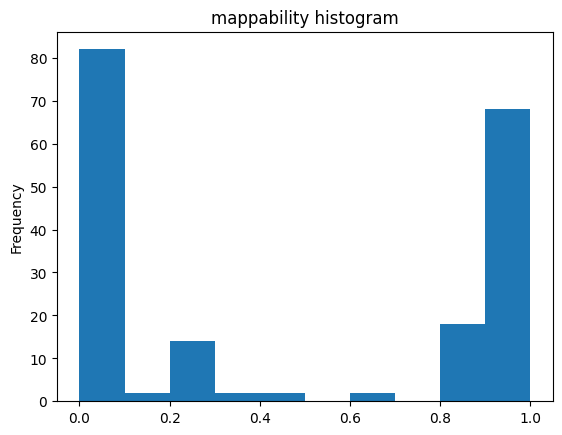

In [61]:
# convert results to a dataframe 
df = t.iterator().to_dataframe()

# Use the pandas query method to show features from protein_coding genes with non-zero mappability...
display(SEP, "Dataframe representation, filtered for gene_type=='protein_coding' & mappability>0", 
        df.query('gene_type=="protein_coding" & mappability>0').head(3),SEP)

# ...and plot the overall mappability distribution...
_ = df['mappability'].plot(kind='hist', title='mappability histogram')

# Summary

In this notebook, we demonstrated the basic elements of *rnalib*'s API: 

* how to instantiate a transcriptome from a GFF file,
* how to access and query its features and
* how to use *genomic iterators* to integrate and annotate it with other genomic datasets. 

Note that you can also add arbitrary custom features (e.g., genomic intervals representing regulatory regions) to a transcriptome, 
save and load annotations to/from disk, export them to GFF3 files or convert them to a bioframe compatible dataframe and much more. 
See the [AdvancedUsage notebook](AdvancedUsage.ipynb) for further details.

This concludes our introduction to the basic *rnalib* API. 
Please see our [AdvancedUsage notebook](AdvancedUsage.ipynb) for more advanced usage examples or 
refer to our [other notebooks](https://github.com/popitsch/rnalib/tree/main/notebooks) for realistic application scenarios 
of *rnalib* and to the [test classes](https://github.com/popitsch/rnalib/tree/main/tests) for more usage examples.